In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os
os.chdir('/content/drive/MyDrive/PR_202210835/Lab02')

## 1. 히스토그램 평활화

In [ ]:
img = cv2.imread("lab02_zebra.jpg", cv2.IMREAD_GRAYSCALE)
print(img.shape)

(342, 392)


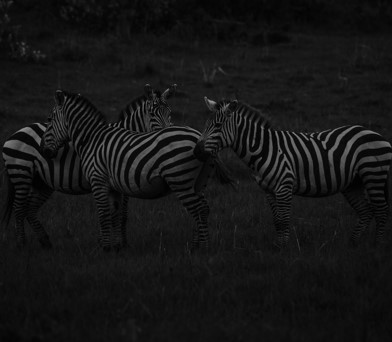

In [ ]:
cv2_imshow(img)

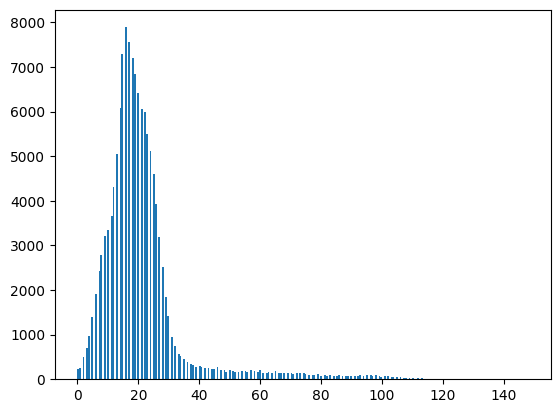

In [ ]:
plt.hist(img.flatten(), bins=256);

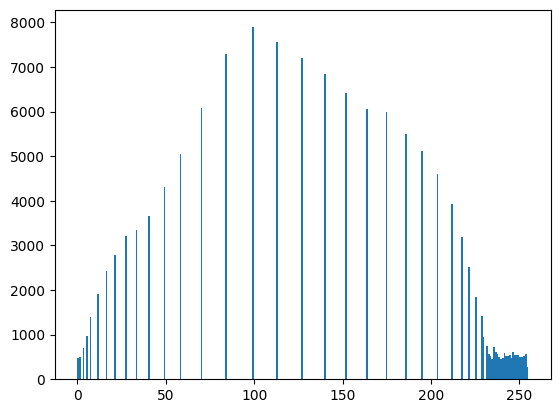

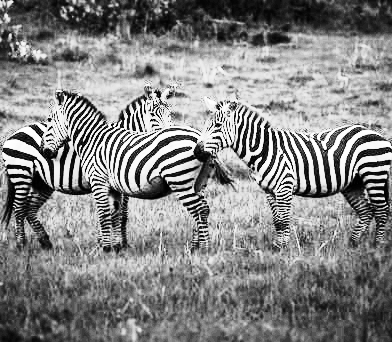

In [ ]:
imgEqualize = cv2.equalizeHist(img)
plt.hist(imgEqualize.flatten(), bins=256);
plt.show();
cv2_imshow(imgEqualize)

## 2. 히스토그램 역투영

### 작년에 이 부분 냈었음
빈칸 뚫린부분 잘 보깅

In [ ]:
targetimg = cv2.imread("lab02_person.jpg")
modelimg = cv2.imread("lab02_modelpatch.jpg")

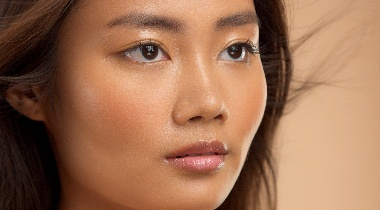

In [ ]:
cv2_imshow(targetimg)

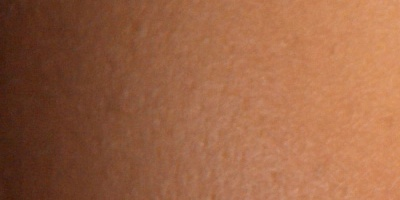

In [ ]:
cv2_imshow(modelimg)

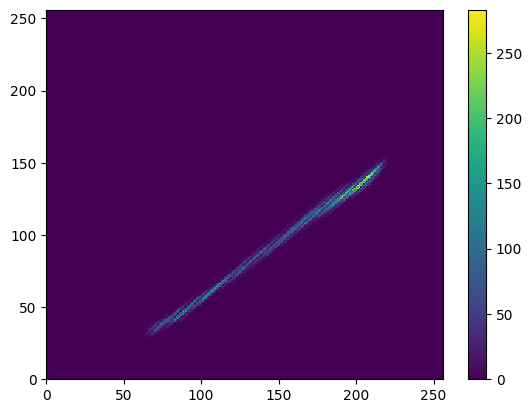

In [ ]:
## BGR 채널에서 G, R 사용
# [1,2]가 G,R 을 사용한다는 내
modelhist = cv2.calcHist([modelimg], [1,2], None, [256, 256], [0,256,0,256])
plt.pcolor(modelhist)
# plt.imshow(modelhist)
plt.colorbar()
plt.show()

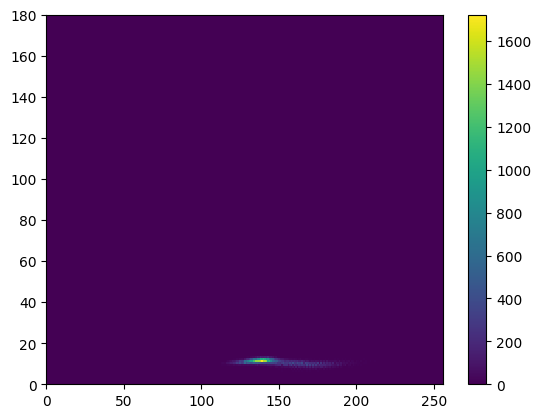

In [ ]:
## HSV 채널에서 H, S 사용
'''
이미지 modelimg를 HSV 채널로 변경하고
modelhist_hsv 에 H와 S 채널 히스토그램 만들기
'''

modelimg_hsv = cv2.cvtColor(modelimg, cv2.COLOR_BGR2HSV) # HSV 채널로 변경
modelhist_hsv = cv2.calcHist([modelimg_hsv], [0,1], None, [180, 256], [0,180,0,256])

plt.pcolor(modelhist_hsv)
plt.colorbar()
plt.show()

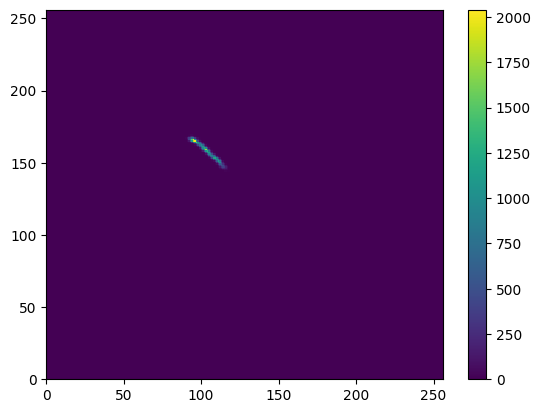

In [ ]:
## YCbCr 채널에서 Cb, Cr 사용
'''
이미지 modelimg를 YCbCr 채널로 변경하고
modelhist_ycbcr 에 Cb와 Cr 채널 히스토그램 만들기
'''
modelimg_ycbcr = cv2.cvtColor(modelimg, cv2.COLOR_BGR2YCrCb) # HSV 채널로 변경
modelhist_ycbcr = cv2.calcHist([modelimg_ycbcr], [1,2], None, [256, 256], [0,256,0,256])

plt.pcolor(modelhist_ycbcr)
plt.colorbar()
plt.show()

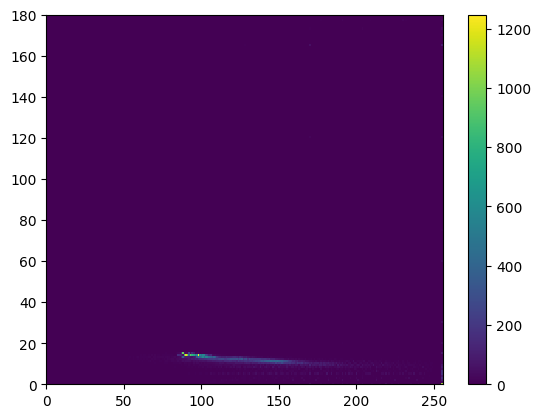

In [ ]:
## Target 이미지도 HSV 채널로 변경
'''
이미지 targetimg를 HSV 채널로 변경하고
targethist_hsv 에 H와 S 채널 히스토그램 만들기
'''
targetimg_hsv = cv2.cvtColor(targetimg, cv2.COLOR_BGR2HSV) # HSV 채널로 변경
targethist_hsv = cv2.calcHist([targetimg_hsv], [0,1], None, [180, 256], [0,180,0,256])

plt.pcolor(targethist_hsv)
plt.colorbar()
plt.show()

In [ ]:
## Model과 target 이미지의 histogram 정규화

modelhist_hsv = modelhist_hsv/modelimg.size # 3으로 나눠줘도 되고 안 나눠줘도 됨
targethist_hsv = targethist_hsv/targetimg.size

## 최대 값이 1보다 작음
print("Max value of Model hist {}".format(modelhist_hsv.max()))
print("Max value of Target hist {}".format(targethist_hsv.max()))

Max value of Model hist 0.007179166666666667
Max value of Target hist 0.005208855472013367


In [ ]:
## 비율 히스토그램 생성
hist_r = modelhist_hsv/ (targethist_hsv + 1e-7)
hist_r = np.minimum(hist_r, 1.0)

In [ ]:
hist_r.shape

(180, 256)

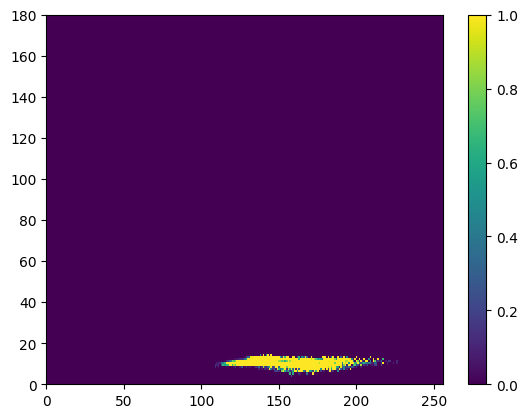

In [ ]:
plt.pcolor(hist_r)
plt.colorbar()
plt.show()

In [ ]:
## 출력 이미지 저장을 위한 배열 생성
height, width = targetimg.shape[0], targetimg.shape[1]
output = np.zeros_like(targetimg, dtype='float32')

In [ ]:
for i in range(height):
  for j in range(width):
    '''
    비율 히스토그램을 통해
    각 pixel에 대한 confidence 구하기
    '''
    h_val = targetimg_hsv[i,j,0]
    s_val = targetimg_hsv[i,j,1]
    confidence = hist_r[h_val, s_val]


    output[i,j] = confidence

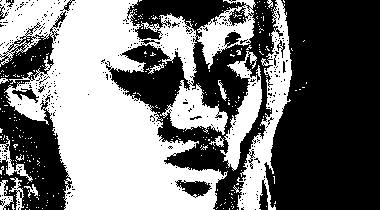

In [ ]:
ret, masked = cv2.threshold(output, 0.02, 255, cv2.THRESH_BINARY)
cv2_imshow(masked)

# 3. 컨볼루션 필터 학습

In [ ]:
import tensorflow as tf

# MNIST 데이터셋 로드
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0  # 이미지 정규화
X_train = np.expand_dims(X_train, axis=-1)    # 채널 차원 추가 (64, 64, 1)

# 학습에 사용할 데이터 크기 제한
X_train = X_train[:1000]  # 예제에서는 1000개만 사용

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


보통 이미지는 0에서 1로 정규화 후 사용

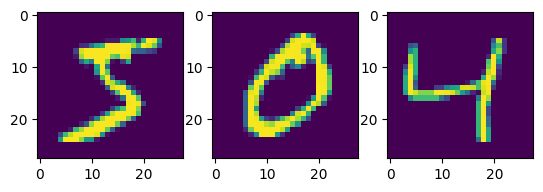

In [ ]:
'''
X_train 데이터 시각화
'''
plt.subplot(1,3,1)
plt.imshow(X_train[0])
plt.subplot(1,3,2)
plt.imshow(X_train[1])
plt.subplot(1,3,3)
plt.imshow(X_train[2])
plt.show()

In [ ]:
# 필터(커널) 생성: 3x3 필터
# true_kernel = ''' 사용할 필터 사전에 입력하기 '''
true_kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=np.float32)
true_kernel = true_kernel.reshape((3, 3, 1, 1))  # (height, width, input_channels, output_channels)

In [ ]:
# 필터를 적용하여 출력 이미지 (Y) 생성
Y_train = tf.nn.conv2d(X_train, true_kernel, strides=1, padding='SAME').numpy()

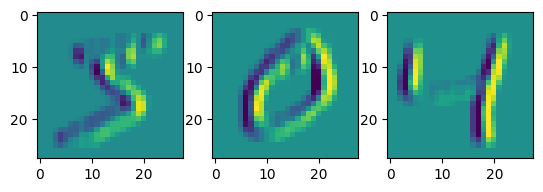

In [ ]:
'''
Y_train 데이터 시각화
'''
plt.subplot(1,3,1)
plt.imshow(Y_train[0])
plt.subplot(1,3,2)
plt.imshow(Y_train[1])
plt.subplot(1,3,3)
plt.imshow(Y_train[2])
plt.show()

In [ ]:
# CNN 모델 정의: 필터 크기 3x3
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1))
])

# 모델 컴파일: 손실 함수는 MSE, 옵티마이저는 Adam 사용
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, Y_train, epochs=100)

In [ ]:
# CNN 모델 정의: 필터 크기 3x3
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1))
])

# 모델 컴파일: 손실 함수는 MSE, 옵티마이저는 Adam 사용
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, Y_train, epochs=200)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9245
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8682
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8169
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7671
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7303
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6732
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6395
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5945
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5616
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5245
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4944
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4575
Epoch 13/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4262
Epoch 14/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3952
Epoch 15/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.366

In [ ]:
# CNN 모델 정의: 필터 크기 3x3
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1))
])

# 모델 컴파일: 손실 함수는 MSE, 옵티마이저는 Adam 사용
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, Y_train, epochs=300)

Epoch 1/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6254
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5803
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5437
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5095
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4790
Epoch 6/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4444
Epoch 7/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4142
Epoch 8/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3904
Epoch 9/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3647
Epoch 10/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3401
Epoch 11/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3185
Epoch 12/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2907
Epoch 13/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2723
Epoch 14/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2522
Epoch 15/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2365
Epoc

In [ ]:
# 학습된 커널(필터) 출력
learned_kernel = model.layers[0].get_weights()[0]
print("학습된 커널 (필터):\n", learned_kernel)

# 실제 커널과 학습된 커널 비교
print("실제 커널 (필터):\n", true_kernel)

학습된 커널 (필터):
 [[[[ 9.9999601e-01]]

  [[ 4.1280555e-06]]

  [[-1.0000036e+00]]]


 [[[ 1.0000066e+00]]

  [[-5.9282356e-06]]

  [[-9.9999493e-01]]]


 [[[ 9.9999619e-01]]

  [[ 3.7550265e-06]]

  [[-1.0000030e+00]]]]
실제 커널 (필터):
 [[[[ 1.]]

  [[ 0.]]

  [[-1.]]]


 [[[ 1.]]

  [[ 0.]]

  [[-1.]]]


 [[[ 1.]]

  [[ 0.]]

  [[-1.]]]]


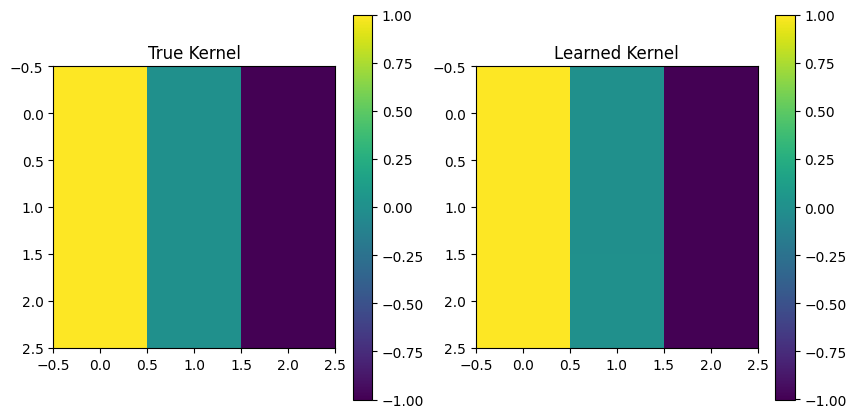

In [ ]:
# 커널 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 첫 번째 이미지: true_kernel
im1 = axes[0].imshow(true_kernel.reshape(3,3))
axes[0].set_title("True Kernel")
fig.colorbar(im1, ax=axes[0])  # colorbar 추가

# 두 번째 이미지: learned_kernel
im2 = axes[1].imshow(learned_kernel.reshape(3,3))
axes[1].set_title("Learned Kernel")
fig.colorbar(im2, ax=axes[1])  #  colorbar 추가

# 그래프 표시
plt.show()

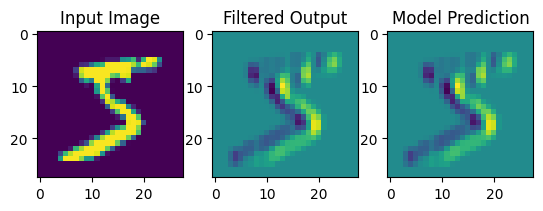

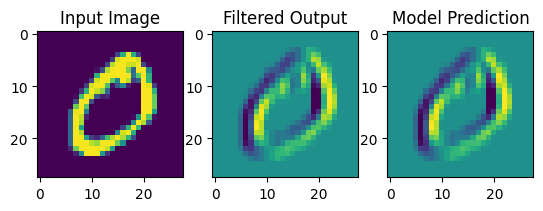

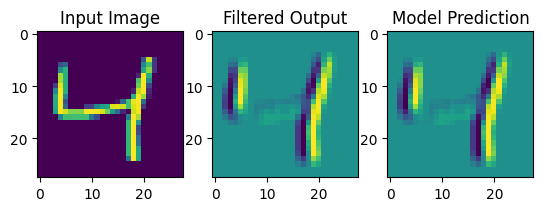

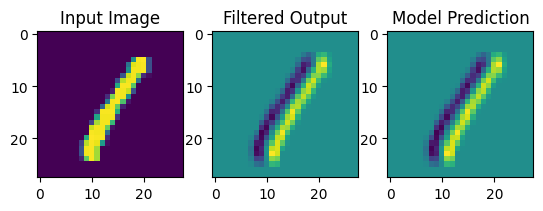

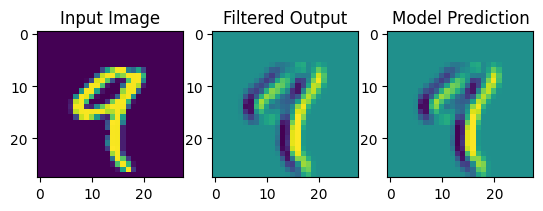

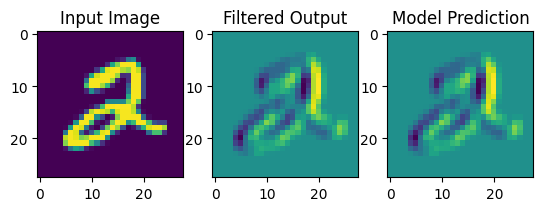

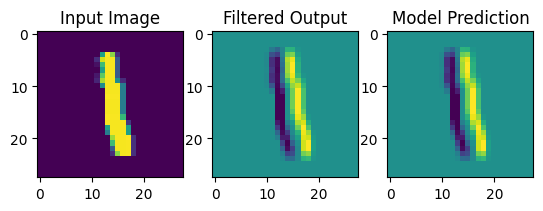

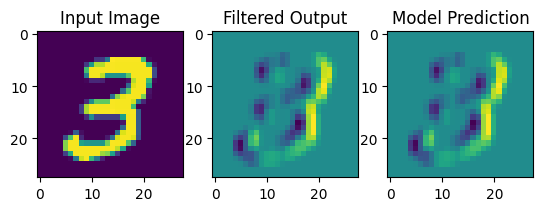

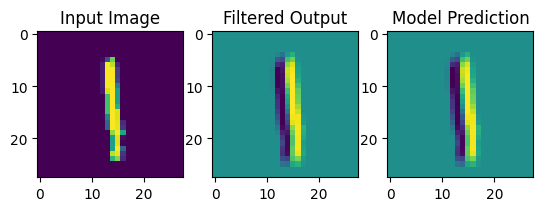

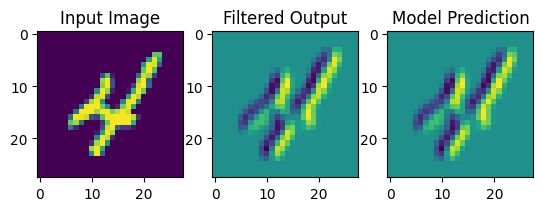

In [ ]:
# 두가지 필터를 사용한 출력 결과 비교하기

for idx in range(10):

  # 입력 데이터
  plt.subplot(1, 3, 1)
  plt.imshow(X_train[idx])
  plt.title("Input Image")

  # 필터 적용된 이미지
  plt.subplot(1, 3, 2)
  plt.imshow(Y_train[idx])
  plt.title("Filtered Output")

  # 모델의 예측 결과 (X_train[0]을 모델에 통과시킨 결과)
  predicted_output = model(X_train[idx].reshape((1, 28, 28, 1))).numpy()
  plt.subplot(1, 3, 3)
  plt.imshow(predicted_output.reshape(28, 28))
  plt.title("Model Prediction")
  plt.show()

In [3]:
!jupyter nbconvert --to html Lab02.ipynb

[NbConvertApp] WARNING | pattern 'Lab02.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execu